<a href="https://colab.research.google.com/github/matheus-piah/google_colabs/blob/main/PreProcessing_Medical_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Algorithm Pre Process Dicom Images

## Pydicom Install

In [ ]:
!pip install pydicom


ERROR: Could not find a version that satisfies the requirement cv2 (from versions: none)
ERROR: No matching distribution found for cv2


# Import Libraries

In [ ]:
import pydicom
import numpy as np
import cv2
import pylab
import math
from skimage import morphology
from scipy import ndimage
from google.colab import drive
from matplotlib import pyplot as plt


drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Importar Imagem

In [ ]:
file_path = '/content/drive/My Drive/Colab Notebooks/ct_imagem_covid_teste.dcm'
medical_image = pydicom.read_file(file_path)
print(medical_image)


Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 184
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.392.200036.9116.2.6.1.37.2420784519.1586489593.394652
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.3.6.1.4.1.32203
(0002, 0013) Implementation Version Name         SH: 'PIXEON'
-------------------------------------------------
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.392.200036.9116.2.6.1.37.2420784519.1586489593.394652
(0008, 0020) Study Date                          DA: '20200410'
(0008, 0021) Series Date                         DA: '

## Gets Image Array From Dicom Image

In [ ]:
image = medical_image.pixel_array
print(image.shape)

(512, 512)


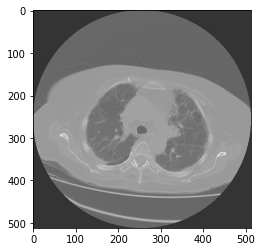

In [ ]:
plt.imshow(image, cmap='gray')


In [ ]:
print(image.min())
print(image.max())

-3046
1844


## Rescale Intercept and Slope

In [ ]:
def transform_to_hu(medical_image, image):
  '''
  The .RescaleSlope is a property in the Dicom image which say 
  how we have to rescale the slope to obtain the correct gray levels

  '''
  intercept = medical_image.RescaleIntercept
  slope = medical_image.RescaleSlope
  hu_image = image * slope + intercept

  return hu_image

Janelamento

In [ ]:
def window_image(image, window_center, windows_width):
  '''
  Function to define the gray levels in the window displayed 
  '''
  img_min = window_center - windows_width //2
  img_max = window_center + windows_width //2
  window_image = image.copy()
  window_image[window_image < img_min] = img_min
  window_image[window_image > img_max] = img_max

  return window_image


## Removing Noises

In [ ]:
def remove_noise(file_path, display = False):
  '''
  During preprocess, removing noises is a very important stage since, the 
  data is improved after the implementation we can see it more clearly. 
  So, model can be trained better. [2]
  '''

  medical_image = pydicom.read_file(file_path)
  image = medical_image.pixel_array

  hu_image = transform_to_hu(medical_image, image)
  chest_image = window_image(hu_image, 40, 80) #bone window
  segmentation = morphology.dilation(chest_image, np.ones((1,1)))
  labels, label_nb = ndimage.label(segmentation)

  label_count = np.bincount(labels.ravel().astype(np.int))
  label_count[0] = 0

  mask = labels == label_count.argmax()

  mask = morphology.dilation(mask, np.ones(1, 1))
  mask = ndimage.morphology.binary_fill_holes(mask)
  mask = morphology.dilation(mask, np.one((3, 3)))
  masked_image = mask * chest_image

  return masked_image


In [ ]:
img_wo_noise = remove_noise(file_path)
plt.imshow(img_wo_noise, cmap='gray')

## Tilt Correction

In [ ]:
'''
Essa rte do código ainda precisa de correção

Tilt correction is the alignment of brain image in a proposed way.
 When tilt experienced by brain CT images, it may result in misalignment 
 for medical applications. It is important because when we train the model, 
 it can see the whole data through the same alignment. Manually correcting 
 the tilt on a large scale data is time-consuming and expensive. Thus, there 
 is a need for an automatic way of performing tilt correction in preprocessing 
 before the training.


'''

img=np.uint8 (iskemiMaskedImg)
contours, hier =cv2.findContours (img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
mask=np.zeros (img.shape, np.uint8)

# find the biggest contour (c) by the area
c = max(contours, key = cv2.contourArea)

(x,y),(MA,ma),angle = cv2.fitEllipse(c)

cv2.ellipse(img, ((x,y), (MA,ma), angle), color=(0, 255, 0), thickness=2)

rmajor = max(MA,ma)/2
if angle > 90:
    angle -= 90
else:
    angle += 96
xtop = x + math.cos(math.radians(angle))*rmajor
ytop = y + math.sin(math.radians(angle))*rmajor
xbot = x + math.cos(math.radians(angle+180))*rmajor
ybot = y + math.sin(math.radians(angle+180))*rmajor
cv2.line(img, (int(xtop),int(ytop)), (int(xbot),int(ybot)), (0, 255, 0), 3)

pylab.imshow(img)
pylab.show()

M = cv2.getRotationMatrix2D((x, y), angle-90, 1)  #transformation matrix

img = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]), cv2.INTER_CUBIC)

pylab.imshow(img)
pylab.show()

NameError: ignored

### Crop Image and Add Pad

In [ ]:
'''
Necessita revisão


Cropping image is needed to place the brain image at the center and get 
rid of unnecessary parts of image. Also, some brain images might be placed 
in different location within general image. By cropping image and adding 
pads, we will make sure almost all the images are in same location within
general image itself.
'''
def crop_image(image, display = False):
  #Create a mask with the background pixels
  mask = image == 0

  #Find The brain area
  coords = np.array(np.nonzero(~mask))
  top_left = np.min(coords, axis=1)
  bottom_right = np.max(coords, axis=1)

  #Remove the background
  croped_image = image[top_left[0]:bottom_right[0],
                       top_left[1]:bottom_right[1]]

  return croped_image

In [ ]:
croppedImage = crop_image(img)

In [ ]:
plt.figure(figsize=(15,5))
plt.imshow(croppedImage)

In [ ]:
### Add Pad function

def add_pad(image, new_height=512, new_width=512):
  height, width = image.shape

  final_image = np.zeros((new_height, new_width))

  pad_left = int((new_width - width) // 2)
  pad_top = int((new_height - height) // 2)

  # Replace the pixels with the image's pixels
  final_image[pad_top:pad_top + height, pad_left:pad_left + width] = image

  return final_image